# EGamma short exercise
This is the companion notebook to [SWGuideCMSDataAnalysisSchoolLPC2023EGammaExercise](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolLPC2023EGammaShortExercise).

Photons and electrons play a crucial role in the success of CMS. They were vital in the discovery of the Higgs boson and play an important role in searches for new physics and standard model measurements. The CMS detector features a high-resolution electromagnetic calorimeter (ECAL) and the world's largest active silicon tracker. These detectors provide clean object identification and excellent energy and momentum resolution of photons and electrons. Within CMS, the [EGamma POG](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaPOG) has the responsibility to "study, develop, characterize and validate the tools to identify and reconstruct electrons and photons." In this exercise, we will examine photon and electron identification and study how these objects are used in physics analyses. We will start with [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) samples.

Table of contents:
   * [Finding samples](#Finding-samples)
   * [Using NanoAOD](#Using-NanoAOD)
   * [Array programming primer](#Array-programming-primer)
   * [Ground truth](#Ground-truth)
   * [Discriminating variables](#Discriminating-variables)
      * [Shower shape](#Shower-shape)
      * [Isolation](#Isolation)
      * [Electron-specific variables](#Electron-specific-variables)
      * [Photon-specific variables](#Photon-specific-variables)
   * [Cut optimization](#Cut-optimization)
   * [Tag and probe](#Tag-and-probe)

## Finding samples
Let's find two simulation samples to use for the remainder of the exercise: a $Z\rightarrow \ell^{+}\ell^{-}$ sample, which will contain two electrons in slightly more than 1/3 of the events (**Q: why greater than a third?**); and a sample of $\gamma+\text{jets}$ events, where a photon is radiated off either initial- or final-state quarks.  To find samples via a web browser, one can go to the [DAS client](https://cmsweb.cern.ch/das/) page.  Here, we use the `dasgoclient` command-line utility, using Jupyter notebook's shell execution shortcut (the ! symbol).

The query format is `dasgoclient --query="key requirement [requirement ...]"` where the key is what type of record we are looking for, and each requirement helps filter results.  Here we want to find some datasets that match a wildcard pattern.  Datasets in CMS (mostly) follow a structured naming convention,

```/Primary/Campaign-Conditions-Revision/Datatier```,

where: `Primary` is the primary dataset type, either a particular set of triggers for real data, or a particular physics process for simulation; `Campaign` encodes the data reprocessing or simulation generating campaign, for which the most current options for Ultra Legacy campaigns are [listed here](https://twiki.cern.ch/twiki/bin/view/CMS/PdmVRun2LegacyAnalysis); `Conditions` specifies in more detail the reconstruction and/or simulation conditions of the dataset; `Revision` allows for replacement of invalid datasets or extensions (e.g. `_ext1` you might sometimes see); and `Datatier` describes what kind of format and content is in the ROOT files inside the dataset.  Below, we search for a simulation dataset for the Drell-Yan ($Z/\gamma^{*}$) process, where the decay is to two leptons (`ToLL`) and a generator-level mass cut of 50 GeV is imposed.  Adding `_TuneCP5` helps reduce the number of matches where additional generator cuts are present or alternative shower tunes are being used (you can learn more about shower tunes in the generators exercise).  Try removing it to see what kind of exclusive phase spases samples are commonly generated for.  For the generation campaign, we choose the Autumn18 production, which corresponds to the 2018 data-taking conditions.

In [1]:
!dasgoclient --query="dataset dataset=/DYJetsToLL_M-50_TuneCP5*/RunIISummer20UL18NanoAODv9-106X*/NANOAODSIM"

/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM
/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1_ext1-v1/NANOAODSIM


We see three results, all are produced with the [MadGraph5_aMC@NLO](https://twiki.cern.ch/twiki/bin/view/CMS/CitationsForGenerators#MadGraph5_a_MCatNLO) generator, where one simulates the Z+jets process at leading order (`madgraphMLM`), one at NLO (`amcatnloFXFX`), and one which is just an extension to increase the number of simulated events.  From here, it is possible albeit convoluted to see the original run cards that configured the MadGraph generator.  We tracked them down for you, so if you are curious you can see what actually configures the event generation: [madgraphMLM card](https://github.com/cms-sw/genproductions/tree/1e06dc8f0c86ab6fdb547b27c43c92b022608b80/bin/MadGraph5_aMCatNLO/cards/production/2017/13TeV/DYJets_HT_LO_MLM/DYJets_HT_mll50/DYJets_HT-incl), [amcatnloFXFX card](https://github.com/cms-sw/genproductions/tree/59237cf5f41aed600b63fa8d071441129aeb6f9a/bin/MadGraph5_aMCatNLO/cards/production/2017/13TeV/dyellell012j_5f_NLO_FXFX
).

Let's use the LO sample.  Below, we query the files belonging to the dataset, and save them to a python variable.

In [2]:
dy_files = !dasgoclient --query="file dataset=/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM"
print("Number of files:", len(dy_files))
print("First file name:",dy_files[0])

Number of files: 71
First file name: /store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/525CD279-3344-6043-98B9-2EA8A96623E4.root


Now, for the photon event samples, since the inclusive production phase space is so large, we have to impose a minimum transverse energy sum requirement (`HT`, i.e. $\sum_{\text{particles}} p_{T}$) to be able to generate enough events in the phase space we are interested in (which is dictated by photon trigger thresholds).

In [3]:
!dasgoclient --query="dataset dataset=/GJets_HT-*/RunIISummer20UL18NanoAODv9-106X*/NANOAODSIM"

/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
/GJets_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
/GJets_HT-40To100_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
/GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM


Let's use just one HT bin for our photon sample.  We will investigate how much that restricts the generated photon $p_{T}$.

In [4]:
gjets_files = !dasgoclient --query="file dataset=/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM"
print("Number of files:", len(gjets_files))

Number of files: 50


The files we've identified above are all LFNs (Logical File Names), and they alone don't specify where and how to read them.  For that, we need to specify a PFN (Physical File Name).  CMS operates a distributed data access system known as [AAA](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookXrootdService) which makes files available via the [xrootd protocol](https://xrootd.slac.stanford.edu/) regardless of their storage location.  In short, adding the prefix `root://cmsxrootd.fnal.gov/` to all the files makes them readable.

In [5]:
redirector = 'root://cmsxrootd.fnal.gov/'
dy_files = [redirector + f for f in dy_files]
gjets_files = [redirector + f for f in gjets_files]

print(dy_files[0])
print(gjets_files[0])

root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/280000/525CD279-3344-6043-98B9-2EA8A96623E4.root
root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL18NanoAODv9/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2560000/8316E3E3-C9FD-914C-9AE2-DF47143B5BD5.root


## Using NanoAOD
In previous iterations of this exercise, students started by running an _NTuplizer_ over MiniAOD samples.  The MiniAOD datatier contains enough detailed information to cover essentially all typical CMS analyses.  The EGamma-related Ultra Legacy content and recipes are discussed further in [EgammaUL2016To2018](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaUL2016To2018) TWiki. 

A plethora of nTuplizers have been written over the past few years, all essentially extracting similar information from MiniAOD.  In an attempt to reduce code maintenence burden, a common nTuple, [NanoAOD](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD) was created.  It contains less information than MiniAOD, and is a much more compact file format, averaging 1-2 kB per event vs. MiniAOD's 30-50 kB per event.  In addition, NanoAOD saves all information in basic types (like `int`, `float`, etc.) rather than the [EDM format](https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookCMSSWFramework#EdM) used for all parent datatiers.  This means that no CMSSW environment is necessary to read these files.  In fact, we will not even use the ROOT framework to analyze these files in this exercise!

For analyses that require information not available in standard NanoAOD, one can create _private NanoAOD_, where  missing variables and/or CMSSW framework modules are added to the [configuration](https://github.com/cms-sw/cmssw/blob/master/PhysicsTools/NanoAOD/python/nano_cff.py) and then CRAB workflows are used to re-extract the information from the parent MiniAOD dataset.  The CMS [cross-POG forum](https://indico.cern.ch/category/5517/) exists to also allow users to petition for certain variables to be added to central NanoAOD.  For the purposes of this exercise, all standard EGamma variables can already be found in NanoAOD.

Below, we examine the content of a NanoAOD file using [uproot](https://uproot.readthedocs.io/en/latest/?badge=latest#).

In [6]:
import uproot
file = uproot.open(dy_files[0])
dict(file)

{'tag;1': <TObjString 'untagged' at 0x7fe8957285f0>,
 'Events;1': <TTree 'Events' (1628 branches) at 0x7fe89572aa30>,
 'LuminosityBlocks;1': <TTree 'LuminosityBlocks' (2 branches) at 0x7fe895ec6bb0>,
 'Runs;1': <TTree 'Runs' (8 branches) at 0x7fe895ec6cd0>,
 'MetaData;1': <TTree 'MetaData' (1 branches) at 0x7fe89572ae20>,
 'ParameterSets;1': <TTree 'ParameterSets' (1 branches) at 0x7fe8552b3820>}

The item of interest here is the `Events` [TTree](https://root.cern.ch/doc/master/classTTree.html) object.  Let's see what is inside it:

In [7]:
tree = file['Events']
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
HTXS_Higgs_pt        | float                    | AsDtype('>f4')
HTXS_Higgs_y         | float                    | AsDtype('>f4')
HTXS_stage1_1_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_1_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_1_fin... | int32_t                  | AsDtype('>i4')
HTXS_stage1_1_fin... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_fin... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_fin... | int32_t                  | AsDtype(

Wow, that's a lot of stuff!  What is shown here is each column (a ROOT [TBranch](https://root.cern.ch/doc/master/classTBranch.html)) inside the tree, along with some interpretation information.  Another source of this information is [this website](https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc102X_doc.html) (and its' parent folder contains branch lists for other NanoAOD versions.)

To help organize all this content, we'll use the [coffea](https://coffeateam.github.io/coffea/) NanoEvents class.  Also, for performance reasons, we've made a local replica of the files at the LPC.

In [8]:
from coffea.nanoevents import NanoEventsFactory

dyevents = NanoEventsFactory.from_root(dy_files[0]).events()
gevents = NanoEventsFactory.from_root(gjets_files[0]).events()

In [9]:
dyevents.Electron.fields

['dEscaleDown',
 'dEscaleUp',
 'dEsigmaDown',
 'dEsigmaUp',
 'deltaEtaSC',
 'dr03EcalRecHitSumEt',
 'dr03HcalDepth1TowerSumEt',
 'dr03TkSumPt',
 'dr03TkSumPtHEEP',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eCorr',
 'eInvMinusPInv',
 'energyErr',
 'eta',
 'hoe',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaFall17V2Iso',
 'mvaFall17V2noIso',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'scEtOverPt',
 'sieie',
 'sip3d',
 'mvaTTH',
 'charge',
 'cutBased',
 'jetIdx',
 'pdgId',
 'photonIdx',
 'tightCharge',
 'vidNestedWPBitmap',
 'vidNestedWPBitmapHEEP',
 'convVeto',
 'cutBased_HEEP',
 'isPFcand',
 'jetNDauCharged',
 'lostHits',
 'mvaFall17V2Iso_WP80',
 'mvaFall17V2Iso_WP90',
 'mvaFall17V2Iso_WPL',
 'mvaFall17V2noIso_WP80',
 'mvaFall17V2noIso_WP90',
 'mvaFall17V2noIso_WPL',
 'seedGain',
 'genPartIdx',
 'genPartFlav',
 'cleanmask',
 'genPartIdxG',
 'jetIdxG',
 'photonIdxG']

Ok, slightly more manageable content. Try replacing the above cell with `dyevents.Electron.fields` and `dyevents.Photon.fields` to see what EGamma-related columns exist in the tree.

Below shows how to see a short description of a column (also available via the `shift`+`tab` keystroke inside jupyter editor). Try `dyevents.Electron.jetIdx.__doc__` and `dyevents.Electron.lostHits.__doc__`. **Q: What could these values be used for? Why are they associated with an electron?**

In [10]:
dyevents.Electron.cutBased.__doc__

'cut-based ID Fall17 V2 (0:fail, 1:veto, 2:loose, 3:medium, 4:tight)'

## Array programming primer

Before diving into the content, let's give a quick overview of [awkward](https://awkward-array.org/quickstart.html) array syntax, as the NanoEvents structure is an awkward array.  It is an extension of the [numpy](https://numpy.org/) array programming syntax.  If you are unfamiliar with numpy, perhaps glance through the [numpy quickstart](https://docs.scipy.org/doc/numpy/user/quickstart.html) before continuing, in particular the universal function and boolean indexing sections.  The main extensions to numpy that are used here are jagged arrays.  Some basic properties are shown below.

In [11]:
import awkward as ak
import numpy as np

a = ak.Array([[1, 2, 3], [4, -2, 4], [], [5]])
print(repr(a))
print(repr(ak.num(a)))

<Array [[1, 2, 3], [4, -2, 4], [], [5]] type='4 * var * int64'>
<Array [3, 3, 0, 1] type='4 * int64'>


Above is a singly-jagged array, where the first dimension has length 4, and the second dimension has variable length.  The length along that dimension is accessible via the [ak.num function](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) (the default axis is 1 for `ak.num`).  This is like the array `dyevents.Electrons`.  All comparison operators and numpy ufuncs are _broadcast_ over the content, meaning they are applied to each element in the jagged array. For example:

In [12]:
print(a > 2)
print(abs(a))

[[False, False, True], [True, False, True], [], [True]]
[[1, 2, 3], [4, 2, 4], [], [5]]


The jagged array `a > 2` can be used to filter (i.e. select) only those elements that pass the criteria. This is done using the `array[filter]` notation. We will use this syntax later to, for example, select only electrons above a certain pT threshold:

In [13]:
object_cut = (a > 2)
print(object_cut)
print(a[object_cut])

[[False, False, True], [True, False, True], [], [True]]
[[3], [4, 4], [], [5]]


When using jagged arrays in a typical physics analysis, in addition to `object_cuts` we can also have event-level selections. For example, we might want to only select _events_ where `all` electrons in the event have pT above some threshold:

In [14]:
event_cut = ak.all(a > 2, axis=1)
print(event_cut)
print(a[event_cut])

[False, False, True, True]
[[], [5]]


Most utilities in the scientific python "speak" numpy arrays, however they do not know about jagged arrays.  So, for example, when interfacing with [pandas](https://pandas.pydata.org/) or [matplotlib](https://matplotlib.org/) we need to remove the jaggedness by using `ak.flatten`.  Of course, we should do this only after making any event-level selections, as after flattening, that structure is lost.

In [15]:
print(a[event_cut])
print(ak.flatten(a[event_cut]))

[[], [5]]
[5]


Another common awkward type is masked arrays.  The main feature is that certain elements can be [null](https://en.wikipedia.org/wiki/Nullable_type) (syn. N/A, not available, `None`)

In [16]:
b = ak.Array([1, 2, None, 4])
b

<Array [1, 2, None, 4] type='4 * ?int64'>

The null value propagates through any operation, until it is filled in

In [17]:
print(b)
print(ak.fill_none(b, -1))
print(b > 0)
print(ak.fill_none(b, -1) > 0)

[1, 2, None, 4]
[1, 2, -1, 4]
[True, True, None, True]
[True, True, False, True]


In the scientific python ecosystem, [matplotlib](https://matplotlib.org/) is the de facto standard plotting utility. Let's import it, along with [mplhep](https://mplhep.readthedocs.io/en/latest/), a helper library to make HEP plots easier (including CMS style!).

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
mplhep.style.use(mplhep.style.CMS)

In [19]:
# run this again to make sure the figure size updates (a known bug)
mplhep.style.use(mplhep.style.CMS)

## Kinematics
Below is a plot of all reconstructed electrons' transverse momentum ($p_{T}$) in this NanoAOD file.
Try plotting instead the $\eta$ and $\phi$ of the electrons.  Plot the electron `counts`.  Plot the $p_{T}$ of the electrons after applying a cut on $|\eta| < 1.4$.

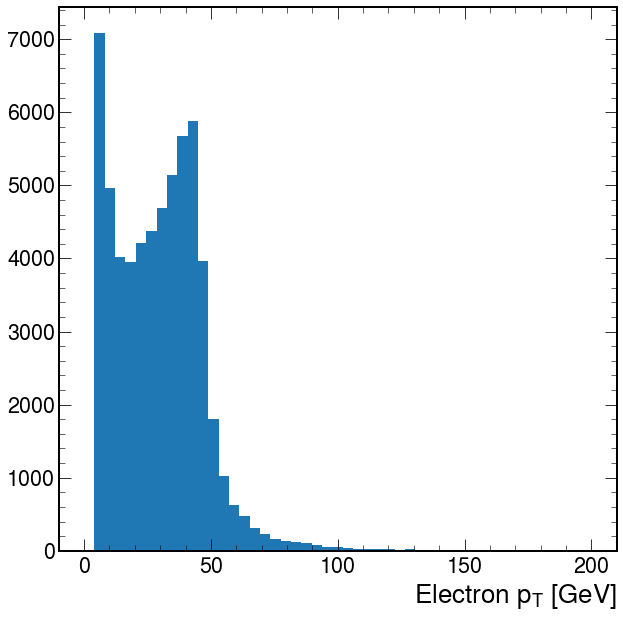

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Electron $p_{T}$ [GeV]')
ax.hist(ak.flatten(dyevents.Electron.pt), bins=np.linspace(0, 200, 50));

Below we plot the invariant mass of all distinct pairs of electrons. The pairs made using the `combinations` function. The `lep1` and `lep2` names are names we assign so we can separately access the first and second electron in the pair.

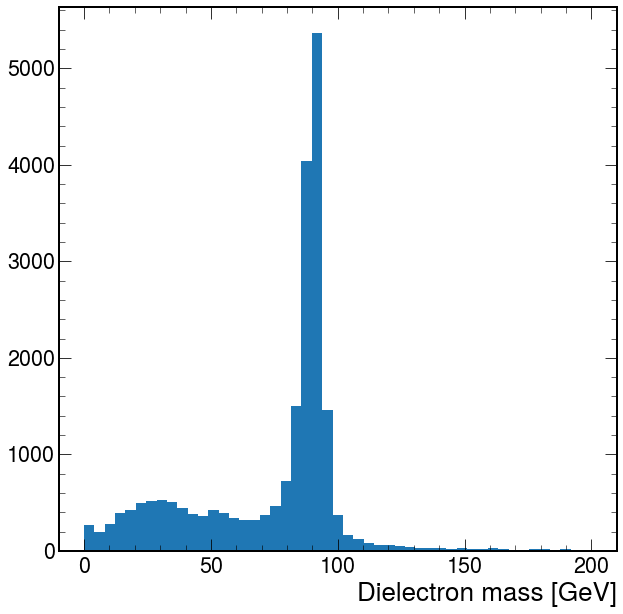

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Dielectron mass [GeV]')

pairs = ak.combinations(dyevents.Electron, 2, fields=["lep1", "lep2"])
mass = (pairs.lep1 + pairs.lep2).mass
ax.hist(ak.flatten(mass), bins=np.linspace(0, 200, 50));

## Ground truth
If we want to identify variables useful to distinguish true electrons and photons from background, we better have a good definition of "true".  Let's take a look at the generated particles that are matched to reconstructed electrons and photons to understand what kind of processes give rise to them.

For electrons and photons, NanoAOD pre-computes the truth-matched particle by finding final-state electron and photon particles in the `GenPart` table that are spatially close (via the metric $\Delta R = \sqrt{(\Delta \eta)^2 + (\Delta \phi)^2}$) to the reconstructed particle.  When no match is found, we get a null/NA value.  Below, we put reconstructed electrons into three buckets: matched to a gen electron, matched to a gen photon, and unmatched, based on the [PDG id](http://pdg.lbl.gov/2018/reviews/rpp2018-rev-monte-carlo-numbering.pdf).  Since for this purpose we don't care so much which event each electron belongs to, we also flatten the array here for convenience.

In [22]:
electrons = ak.flatten(dyevents.Electron)

true_electrons = electrons[ak.fill_none(abs(electrons.matched_gen.pdgId) == 11, False)]
photon_fakes = electrons[ak.fill_none(electrons.matched_gen.pdgId == 22, False)]
unmatched_electrons = electrons[ak.is_none(electrons.matched_gen)]

For the true electrons, we would expect the parent to be a Z boson in these samples.  We can check this using the `distinctParent` attribute stored in our files.  There is also a `parent` attribute, which specifies the direct ancestor to the generated electron, however this could also be an electron (due to final state $\gamma$ radiation and other generator-internal reasons).  The `distinctParent` attribute skips copies of the same particle that are the result of FSR.

Below, we put the `distinctParent` value, along with some other (carefully chosen) gen particle flags, into a pandas dataframe by passing a dictionary. In this dictionary, the key signifies the parameter and the element is a flattened array of that value for every electron in the NanoAOD file. The `ak.zip` groups keyed elements together for each electron, making sure the dataframe is cast correctly where each electron is an entry. We then use `groupby` to create categories that share common values. They are then ranked by the number of electrons, or "counts" that are in that category. We only consider the categories with the top 10 number of entries.

In [23]:
df = ak.to_pandas(
    ak.zip(
        {
            "parentId": abs(true_electrons.matched_gen.distinctParent.pdgId),
            "fromHardProcess": true_electrons.matched_gen.hasFlags(["fromHardProcess"]),
            "isPrompt": true_electrons.matched_gen.hasFlags(["isPrompt"]),
            "isDirectPromptTauDecayProduct": true_electrons.matched_gen.hasFlags(
                ["isDirectPromptTauDecayProduct"]
            ),
        }
    )
)

top10 = (
    df.groupby(list(df.columns))
    .size()
    .rename("count")
    .reset_index()
    .sort_values("count", ascending=False)
)[:10]

top10

,parentId,fromHardProcess,isPrompt,isDirectPromptTauDecayProduct,count
15,23.0,True,True,False,39213
11,15.0,False,False,True,5031
3,2.0,True,True,False,1130
1,1.0,True,True,False,329
6,4.0,True,True,False,258
13,21.0,True,True,False,196
4,3.0,True,True,False,122
16,111.0,False,False,False,58
22,511.0,False,False,False,50
23,521.0,False,False,False,47


Indeed, in most cases, the parent is pdgId `23`, corresponding to the Z boson.  Sometimes the parent is a $\tau$ lepton, and then the remainder are cases where the electron is from a hadron decay (`parentId > 100`) or where the parentage appears somewhat suspect (e.g. pdg IDs less than 6, corresponding to bare quarks... this is a quirk in how MadGraph records the parentage history for off-shell $Z^*/\gamma^*$)  Luckily, a set of flags is embedded in NanoAOD that are more straightforward than travsersing the NanoAOD parentage history.  In our case, we'll take `isPrompt` as the marker for true electrons coming from the hard scatter event.  Since direct $\tau$ decays produce prompt isolated electrons, we include those with `isDirectPromptTauDecayProduct` as well.

In [24]:
promptmatch = true_electrons.matched_gen.hasFlags(['isPrompt'])
promptmatch = promptmatch | true_electrons.matched_gen.hasFlags(['isDirectPromptTauDecayProduct'])
prompt_electrons = true_electrons[promptmatch]
nonprompt_electrons = true_electrons[~promptmatch]

There is also a pre-computed variable `Electron.genPartFlav`, which according to the documentation, has the assignment:

In [25]:
dyevents.Electron.genPartFlav.__doc__

'Flavour of genParticle (DressedLeptons for electrons) for MC matching to status==1 electrons or photons: 1 = prompt electron (including gamma*->mu mu), 15 = electron from prompt tau, 22 = prompt photon (likely conversion), 5 = electron from b, 4 = electron from c, 3 = electron from light or unknown, 0 = unmatched'

Let's see how this compares to our analysis: below we count the number of occurrences of each flavor using [np.unique](https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html) and then print the results.

In [26]:
flavors, counts = np.unique(ak.to_numpy(prompt_electrons.genPartFlav), return_counts=True)
for flavor, count in zip(flavors, counts):
    print("GenPart flavor % 3d has % 8d occurrences" % (flavor, count))

GenPart flavor   1 has    41307 occurrences
GenPart flavor  15 has     5031 occurrences


Try checking our other categories against this pre-computed ground truth categorization by switching out the `prompt_electrons` variable with the others.
For photons, `gevents.Photon.genPartFlav` provides similar categorization.  Below, we use this variable to sort photons into two variables.

In [27]:
photons = ak.flatten(gevents.Photon)
prompt_photons = photons[photons.genPartFlav == 1]
unmatched_photons = photons[photons.genPartFlav == 0]

## Discriminating variables
In the following few cells, we'll introduce typical discriminating variables used to distinguish true hard-process electrons and photon from fakes, and plot them.  Later, we'll look at electron- and photon-specific discriminating variables.

### Shower shape

Shower shape variables are constructed from the energy-weighted spatial distribution of ECAL and HCAL deposits.

   * $\sigma_{i\eta i\eta}$ (`Electron.sieie`) is the energy-weighted standard deviation of integer eta (one per crystal) within the 5×5 crystal cluster centered at the crystal with maximum energy:

$$ \sigma_{i\eta i\eta} = \frac{\sum_{i}^{5x5} w_i (i\eta_i - i\eta_{\text{seed}})}{\sum_i^{5x5} w_i}, \quad w_i = \max(0, 4.7 + \ln E_i - \ln E_{5x5}),$$

where the sum runs over the 5 × 5 crystal matrix around the most energetic crystal in the SuperCluster, and the eta distances are measured in units of the crystal size in the eta direction. This variable represents the second moment of the energy distribution along the eta coordinate.  The integer values are scaled by the nominal crystal $\phi$ width in the barrel which is $\pi / 180 \approx 0.0175$.  PS it is defined [here](https://github.com/cms-sw/cmssw/blob/master/RecoEcal/EgammaCoreTools/interface/EcalClusterLazyTools.h#L252) and implemented [here](https://github.com/cms-sw/cmssw/blob/master/RecoEcal/EgammaCoreTools/interface/EcalClusterTools.h#L1034)

   * $R_9$ (`Electron.r9`) is the ratio of the energy deposited in ECAL inside a 3 × 3 crystal matrix centered on the most energetic crystal in the supercluster and the superCluster raw energy.

   * $H/E$ (`Electron.hoe`) is the ratio of the energy deposited in the single closest HCAL tower to the supercluster position inside a cone of radius 0.15 in the $\eta,\phi$ plane centered on the photon direction and the energy deposited in ECAL to that supercluster.

Below, we plot the $\sigma_{i\eta i\eta}$ variable for true prompt electrons and unmatched electrons, where the minimum electron $p_{T}$ is required to be at least 20 GeV.

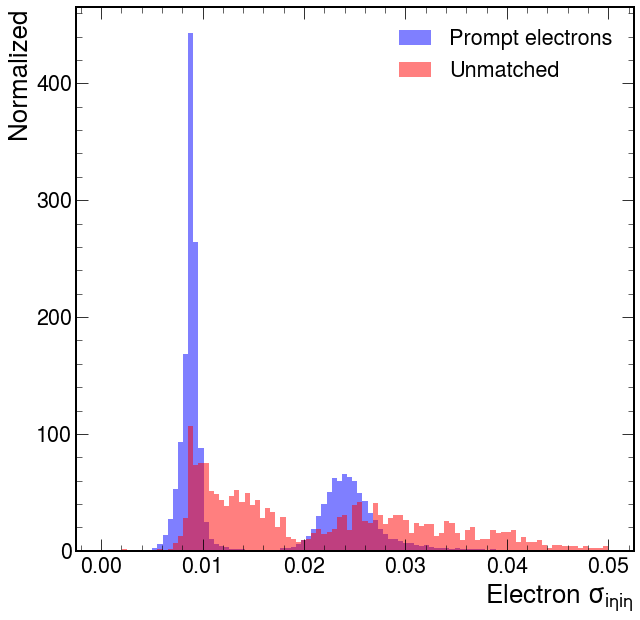

In [28]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Electron $\sigma_{i \eta i \eta}$')
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0, 0.05, 100),
    'density': True,
}

def cut(candidates):
    return candidates[
        (candidates.pt > 20.)
    ]

ax.hist(cut(prompt_electrons).sieie, color='blue', label='Prompt electrons', **common_opts)
# ax.hist(cut(photon_fakes).sieie, color='green', label='Photons', **common_opts)
# ax.hist(cut(nonprompt_electrons).sieie, color='orange', label='Non-prompt electrons', **common_opts)
ax.hist(cut(unmatched_electrons).sieie, color='red', label='Unmatched', **common_opts)

ax.legend()
ax.set_ylabel('Normalized' if common_opts['density'] else 'Events');

Try uncommenting different categories and looking at the distributions.  Any guess as to why the true electrons have a double-peak?  It might help to try looking at `sieie` separately for barrel and endcap reconstructed electrons (hint: modify the filter function to also require `abs(electrons.eta) < 1.4447`).

**Duplicate the above cell and look at R9 and H/E variables.**  P.S. both variables have a natural range of 0 to 1.
Which of the three is your favorite?

Look at each variable as a function of $p_{T}$.  Simple option: draw two histograms, one with electron $p_{T} < 20$GeV cut and one with electron $p_{T} > 80$GeV); fancy option: 2D histogram.  What trends do you notice?

Plot `sieie` for prompt and unmatched photons in the barrel.  Notice the double peak for unmatched?

## Isolation

Isolation variables compare the amount of energy deposited in a region around the reconstructed object to that of the object.  Typically, non-prompt electrons and photons (i.e. from hadron decays) have other energy deposited nearby.  Two particle flow (PF) isolation variables are saved in NanoAOD:

   * PF charged hadron isolation `pfRelIso03_chg`: sum of $p_{T}$ of PF charged hadrons which are associated to the primary vertex, not in the "footprint" of the candidate, and within a cone of $\Delta R < 0.3$,
   * PF total isolation `pfRelIso03_all`: sum of $p_{T}$ of all PF candidates within the cone of $\Delta R < 0.3$,
   
where in both cases, the values are relative to the object $p_{T}$.

Due to pileup (multiple collisions in the same event), some of the PF candidates within this isolation cone may belong to a different collision and therefore this variable has a mild dependence on the number of pileup interactions.  A correction is made to the total isolation to remove this pileup-dependence,

$$I = I_{\text{raw}} - \rho * \text{EA}(|\eta|),$$

where $\rho$ is the median pileup energy density per unit area, a measure of the pileup activity in the event (computed during the jet clustering stage with FastJet, acting on the PF candidates); and EA is the effective area of the electron or photon object, a quantity computed and [made available](https://github.com/lsoffi/cmssw/blob/CMSSW_9_2_X_TnP/RecoEgamma/ElectronIdentification/data/Fall17/effAreaElectrons_cone03_pfNeuHadronsAndPhotons_92X.txt) by the Egamma POG, and is defined as explained in [slide 4 here](https://indico.cern.ch/event/662749/contributions/2763091/attachments/1545124/2424854/talk_electron_ID_fall17.pdf).

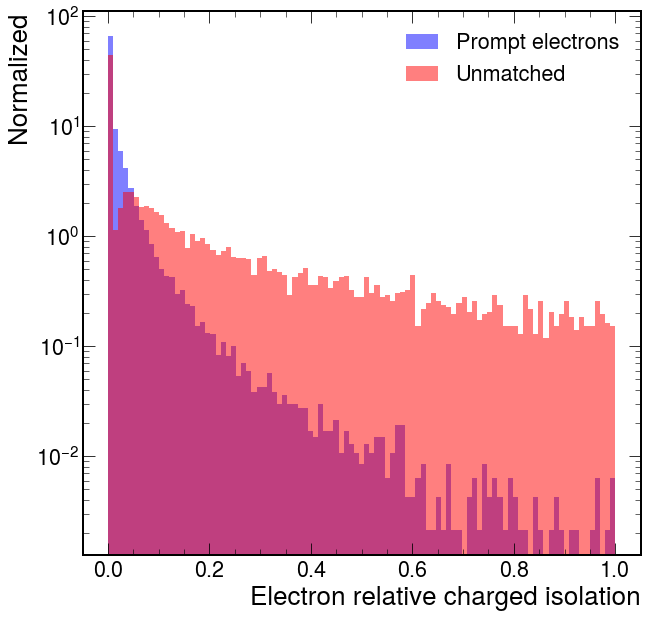

In [29]:
fig, ax = plt.subplots()
ax.set_xlabel(r'Electron relative charged isolation')
common_opts = {
    'alpha': 0.5,
    'bins': np.linspace(0, 1, 100),
    'density': True,
}

ax.hist(prompt_electrons.pfRelIso03_chg, color='blue', label='Prompt electrons', **common_opts)
# ax.hist(photon_fakes.pfRelIso03_chg, color='green', label='Photons', **common_opts)
# ax.hist(nonprompt_electrons.pfRelIso03_chg, color='orange', label='Non-prompt electrons', **common_opts)
ax.hist(unmatched_electrons.pfRelIso03_chg, color='red', label='Unmatched', **common_opts)

ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Normalized' if common_opts['density'] else 'Events');

### Electron-specific variables

   * Mini-isolation `miniPFRelIso_all,miniPFRelIso_chg`: uses a cone whose size varies as a function of the electron $p_{T}$ in order to reduce accidental overlap from hard scatter and pileup processes,
   * Conversion veto `convVeto`: reject photons that converted in the innermost layers of the pixel or tracker detectors

### Photon-specific variables

   * Conversion-safe electron veto `electronVeto`: this cut replaces the detector-based `pixelSeed` used to distinguish between photons and electrons. It checks the $\Delta R$ distance between the photon direction and the nearest electron track and remove photons if there is a GsfElectron matching to the photon supercluster, with no missing hits and having no matching reconstructed conversion.

## Cut optimization

Now that we've seen a few discriminating variables, let's compare their power for differentiating true electrons from background using a [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), which shows signal tagging efficiency as well as background rejection efficiency simultaneously on a 2D plot. Efficiency $\epsilon$ is defined for a given selection as:

$$\epsilon = \frac{n_{\text{pass}}}{n_{\text{pass}}+n_{\text{fail}}} = \frac{n_{\text{pass}}}{n_{\text{total}}}$$

Below we plot the ROC curve for: selected discriminating variables; working points in the ROC of the POG-supported cut-based ID, which is a tuned selection on multiple variables; and the ROC for the POG-supported MVA classifier. Information on all of the POG-supported IDs can be found [here](https://twiki.cern.ch/twiki/bin/view/CMS/EgammaIDRecipesRun2).

**Define a selection on multiple variables, measure its signal and background efficiency, and place a marker on the ROC corresponding to your ID**

In [30]:
def makeroc(sig, bkg, binning, direction=1):
    '''Given a signal and background discriminant array, along with a binning,
    compute the ROC curve by integrating discriminant histograms along a direction:
        1: cut < value
        -1: cut >= value
    Returns a tuple of (signal efficiency, background efficiency)'''
    sighist, _ = np.histogram(ak.to_numpy(sig), bins=binning)
    bkghist, _ = np.histogram(ak.to_numpy(bkg), bins=binning)
    # numpy histogram will ignore values out of range of our binning (overflow)
    # so add the overflow values that would pass given our cut direction
    if direction == 1:
        sighist[0] += sum(sig < binning[0])
        bkghist[0] += sum(bkg < binning[0])
    elif direction == -1:
        sighist[-1] += sum(sig > binning[-1])
        bkghist[-1] += sum(bkg > binning[-1])
    else:
        raise ValueError("Invalid direction")
    sigpass = (np.cumsum(sighist[::direction]) / len(sig))[::direction]
    bkgpass = (np.cumsum(bkghist[::direction]) / len(bkg))[::direction]
    return (sigpass, bkgpass)


def cut(electrons):
    return electrons[
        (electrons.pt > 20)
        & (abs(electrons.eta) < 1.4)
    ]


roc_sieie = makeroc(
    sig=cut(prompt_electrons).sieie,
    bkg=cut(unmatched_electrons).sieie,
    binning=np.linspace(0.005, 0.02, 50),
    direction=1,
)

roc_hoe = makeroc(
    sig=cut(prompt_electrons).hoe,
    bkg=cut(unmatched_electrons).hoe,
    binning=np.linspace(0., 0.3, 50),
    direction=1,
)

roc_mva = makeroc(
    sig=cut(prompt_electrons).mvaFall17V2Iso,
    bkg=cut(unmatched_electrons).mvaFall17V2Iso,
    binning=np.linspace(-1, 1., 50),
    direction=-1,
)

In [31]:
sig_pass = cut(prompt_electrons).cutBased >= prompt_electrons.LOOSE
bkg_pass = cut(unmatched_electrons).cutBased >= prompt_electrons.LOOSE
wp_cutbased_loose = (
    sum(sig_pass) / len(sig_pass),
    sum(bkg_pass) / len(bkg_pass),
)

sig_pass = cut(prompt_electrons).cutBased >= prompt_electrons.TIGHT
bkg_pass = cut(unmatched_electrons).cutBased >= prompt_electrons.TIGHT
wp_cutbased_tight = (
    sum(sig_pass) / len(sig_pass),
    sum(bkg_pass) / len(bkg_pass),
)

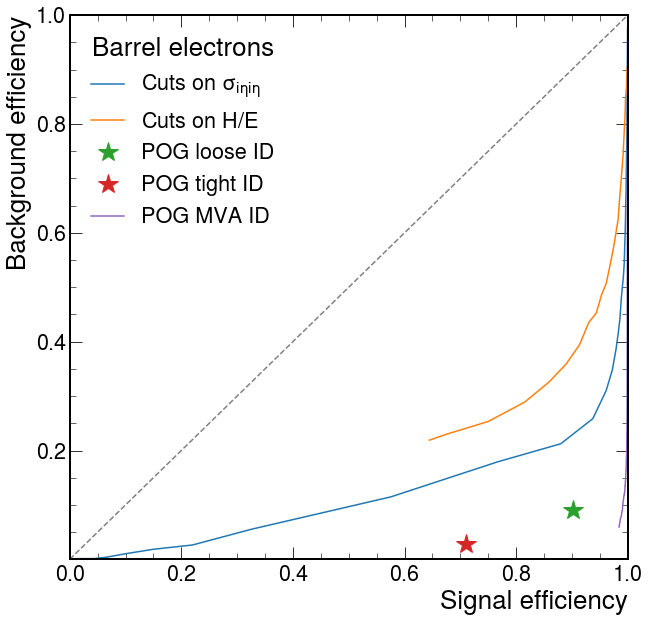

In [32]:
fig, ax = plt.subplots()
ax.plot(*roc_sieie, label=r"Cuts on $\sigma_{i\eta i\eta}$")
ax.plot(*roc_hoe, label=r"Cuts on $H/E$")
ax.plot(*wp_cutbased_loose, label=r"POG loose ID", marker='*', markersize=20, linestyle='none')
ax.plot(*wp_cutbased_tight, label=r"POG tight ID", marker='*', markersize=20, linestyle='none')
ax.plot(*roc_mva, label=r"POG MVA ID")

diag = np.linspace(0, 1, 100)
ax.plot(diag, diag, color='grey', linestyle='--')
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background efficiency")
ax.set_xlim(0, 1)
ax.set_ylim(1e-3, 1)
# ax.set_yscale('log')
ax.legend(title=r'Barrel electrons')

We are also often interested in the efficiency as a function of the electron's kinematics. To help explore the dependency, we can record the number of electrons passing and failing a given selection separately for many small regions in the electron $p_{T}$ and $\eta$, which will allow us to compute the (binned) efficiency as a function of these variables, $\epsilon(p_{T}, \eta)$. We are using the [hist](https://hist.readthedocs.io/en/latest/) package to make a multidimensional histogram to record all these values in one object, which later can be projected as necessary.

In [33]:
import hist

efficiency = hist.Hist(
    hist.axis.StrCategory(["pass", "fail"], name="region", label="Region"),
    hist.axis.Regular(18, 20, 200, name="pt", label=r"$p_{T}$"),
    hist.axis.Regular(25, -2.5, 2.5, name="eta", label=r"$\eta$")
)

passing = prompt_electrons.cutBased >= prompt_electrons.TIGHT
efficiency.fill(region="pass", pt=prompt_electrons[passing].pt, eta=prompt_electrons[passing].eta)
efficiency.fill(region="fail", pt=prompt_electrons[~passing].pt, eta=prompt_electrons[~passing].eta)

efficiency

Hist(
  StrCategory(['pass', 'fail'], name='region', label='Region'),
  Regular(18, 20, 200, name='pt', label='$p_{T}$'),
  Regular(25, -2.5, 2.5, name='eta', label='$\\eta$'),
  storage=Double()) # Sum: 36483.0 (46338.0 with flow)

In the cell below, we project the histogram to recover the binned $n_{\text{pass}}(p_{T})$ (as `num`) and the binned $n_{\text{total}}(p_{T})$ (as `denom`) and plot the ratio $\epsilon(p_{T})$. Modify which axis the histogram is projected onto to see the efficiency as a function of $\eta$.
**Q: is the efficiency symmetric in $\eta$?**
**Q: what might explain the lower efficiency near $|\eta|=1.4$?**

Text(0, 1, '$\\epsilon$')

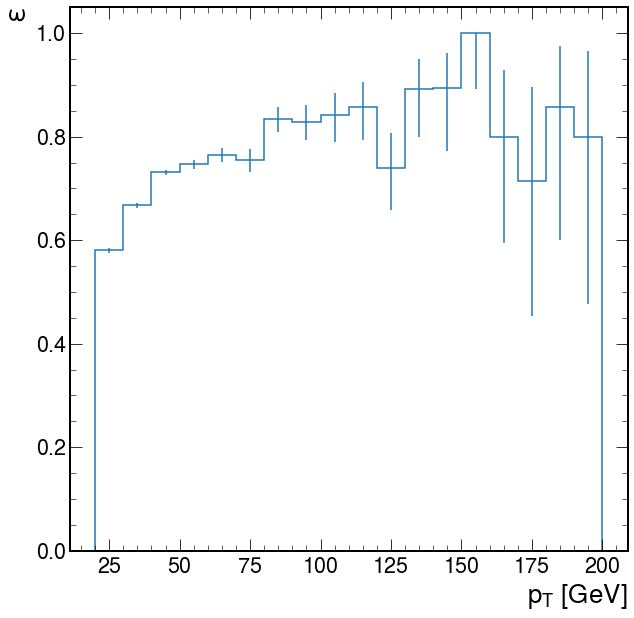

In [34]:
from coffea.hist import clopper_pearson_interval

num = efficiency["pass", ...].project("pt").view()
denom = efficiency.project("pt").view()
edges = efficiency.axes["pt"].edges
err = abs(clopper_pearson_interval(num, denom) - num / denom)

fig, ax = plt.subplots()
mplhep.histplot(num / denom, bins=edges, yerr=err, ax=ax)
ax.set_xlabel("$p_{T}$ [GeV]")
ax.set_ylabel("$\epsilon$")

## Tag and probe

So far, we've computed all our efficiencies using ground truth as provided by our simulation to categorize our signal and background reconstructed electrons.  If we trust our simulation to perfectly describe the detector response, then our job is done.  We cannot do that (**Q: why might we need to know true electron tagging efficiency in data?**), so we need to measure the efficiency in data, categorizing signal and background by inference.  How do we do this without selection bias?  Thanks to the Z boson, we have a solution: tag one electron in an event that passes some high quality requirement, then look for a "probe" electron such that the invariant mass of the di-electron pair ($m_{ee}$) matches that of the Z boson.  If we count the number of probes falling in some mass window that pass and fail our ID, we can infer the true electron tagging efficiency in data, despite not knowing the ground truth for each electron.
Below is a basic example of making a tag and probe selection, then plotting the pass and fail mass distributions, for POG cut-based electron ID, using our simulated Z event sample.

In [35]:
zcands = ak.combinations(dyevents.Electron, 2, fields=["tag", "probe"])
# filter pairs to have a good tag
zcands = zcands[
    (zcands.tag.pt >= 20)
    & (abs(zcands.tag.eta) < 2.1)
    & (zcands.tag.cutBased >= zcands.tag.TIGHT)
]
# filter out events that have no z candidates
zcands = zcands[ak.num(zcands) > 0]
# some events may have multiple candidates, take the leading one (as they are sorted by pt)
zcands = ak.firsts(zcands)
# compute invariant mass
mass = (zcands.tag + zcands.probe).mass

goodprobe = zcands.probe.cutBased >= zcands.probe.LOOSE

Text(1, 0, 'Dielectron mass [GeV]')

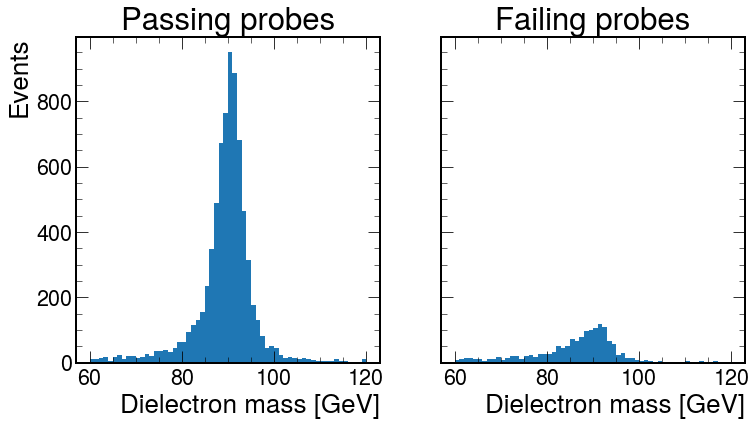

In [36]:
fig, (axp, axf) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
mbins = np.linspace(60, 120, 61)

axp.hist(mass[goodprobe], bins=mbins)
axp.set_title('Passing probes')
axp.set_ylabel('Events')
axp.set_xlabel('Dielectron mass [GeV]')

axf.hist(mass[~goodprobe], bins=mbins)
axf.set_title('Failing probes')
axf.set_xlabel('Dielectron mass [GeV]')

Now make the same plot with low and high probe $p_{T}$ requirements.  How does the mass shape and relative peak height change?

**Plot the same distribution for electrons in real data**

Use your DAS skills to find a file from `/EGamma/Run2018A-UL2018_MiniAODv2_NanoAODv9-v1/NANOAOD` and open it, then make the same selection and plot it.

You'll notice the failing distribution's peak is hidden under a much larger amount of background. This is combinatorial background from random fake electrons combining with the tag to create a continuous falling invariant mass spectrum.  To properly measure the peak height, a full analysis would have to subtract this background by fitting the pass and fail distributions.  If you got this far and are bored, try to use [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to fit each distribution.  Bonus points if you fit them using a simultaneous log likelihood.

If you finish that exercise, figure out what the weather was like in Cessy the day we took the data in that file.  [This page](https://cmsoms.cern.ch/cms/index/index) might be helpful.

## Scale Factors

In [40]:
from correctionlib import _core
import json
import gzip

In [51]:
with gzip.open("/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/EGM/2018_UL/electron.json.gz", mode="rb") as f:
    sfjson = json.loads(f.read().decode("ascii"))#does not work, loses named structure

In [52]:
sfjson

{'schema_version': 2,
 'description': 'These are the electron ID Scale Factors (nominal, up or down) for 2018 Ultra Legacy dataset. They are available for the cut-based and MVA IDs. They are dependent on the transverse momenta and pseudorapidity of the electron. Please keep in the mind that if your analysis is sensitive to high pT electrons (>500 GeV), we recommend you to use HEEP ID. In any case, you have even some electrons above 500 GeV, be careful while applying these SFs.',
 'corrections': [{'name': 'UL-Electron-ID-SF',
   'description': 'These are the electron ID Scale Factors (nominal, up or down) for 2018 Ultra Legacy dataset. They are available for the cut-based and MVA IDs. They are dependent on the transverse momenta and pseudorapidity of the electron.',
   'version': 2,
   'inputs': [{'name': 'year',
     'type': 'string',
     'description': 'year/scenario: example 2016preVFP, 2017 etc'},
    {'name': 'ValType',
     'type': 'string',
     'description': 'sf/sfup/sfdown (s

TypeError: from_file(): incompatible function arguments. The following argument types are supported:
    1. (arg0: str) -> correctionlib._core.CorrectionSet

Invoked with: {'schema_version': 2, 'description': 'These are the electron ID Scale Factors (nominal, up or down) for 2018 Ultra Legacy dataset. They are available for the cut-based and MVA IDs. They are dependent on the transverse momenta and pseudorapidity of the electron. Please keep in the mind that if your analysis is sensitive to high pT electrons (>500 GeV), we recommend you to use HEEP ID. In any case, you have even some electrons above 500 GeV, be careful while applying these SFs.', 'corrections': [{'name': 'UL-Electron-ID-SF', 'description': 'These are the electron ID Scale Factors (nominal, up or down) for 2018 Ultra Legacy dataset. They are available for the cut-based and MVA IDs. They are dependent on the transverse momenta and pseudorapidity of the electron.', 'version': 2, 'inputs': [{'name': 'year', 'type': 'string', 'description': 'year/scenario: example 2016preVFP, 2017 etc'}, {'name': 'ValType', 'type': 'string', 'description': 'sf/sfup/sfdown (sfup = sf + syst, sfdown = sf - syst) '}, {'name': 'WorkingPoint', 'type': 'string', 'description': 'Working Point of choice : Loose, Medium etc.'}, {'name': 'eta', 'type': 'real', 'description': 'supercluster eta'}, {'name': 'pt', 'type': 'real', 'description': 'electron pT'}], 'output': {'name': 'weight', 'type': 'real', 'description': 'value of scale factor (nominal, up or down)'}, 'data': {'nodetype': 'category', 'input': 'year', 'content': [{'key': '2018', 'value': {'nodetype': 'category', 'input': 'ValType', 'content': [{'key': 'sf', 'value': {'nodetype': 'category', 'input': 'WorkingPoint', 'content': [{'key': 'RecoBelow20', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -1.0, 0.0, 1.0, 1.444, 1.566, 2.0, inf], [10.0, 20.0]], 'content': [0.99895179271698, 0.99895179271698, 1.1436463594436646, 0.9888888597488403, 1.0768293142318726, 1.0768293142318726, 0.9888888597488403, 1.1436463594436646, 0.99895179271698, 0.99895179271698], 'flow': 'error'}}, {'key': 'RecoAbove20', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -1.0, -0.5, 0.0, 0.5, 1.0, 1.444, 1.566, 2.0, inf], [20.0, 45.0, 75.0, 100.0, inf]], 'content': [0.9835391044616699, 0.9867075681686401, 0.9969262480735779, 0.9989827275276184, 0.9887179732322693, 0.9887869358062744, 0.9939024448394775, 1.007128357887268, 0.9754385948181152, 0.96592116355896, 1.0338428020477295, 1.0308030843734741, 0.9823834300041199, 0.9835391044616699, 0.9979296326637268, 0.9938271641731262, 0.9886831045150757, 0.9877426028251648, 0.9897330403327942, 0.9959100484848022, 0.9865702390670776, 0.9876922965049744, 0.9897540807723999, 0.9959058165550232, 0.9864583611488342, 0.9855072498321533, 0.9897540807723999, 0.9959058165550232, 0.987525999546051, 0.9886128306388855, 0.9897330403327942, 0.9959100484848022, 0.9791013598442078, 0.98031085729599, 0.9979296326637268, 0.9938271641731262, 0.9870129823684692, 0.9741935729980469, 1.0338428020477295, 1.0308030843734741, 0.9877049326896667, 0.9887869358062744, 0.9939024448394775, 1.007128357887268, 0.9866803288459778, 0.9887869358062744, 0.9969262480735779, 0.9989827275276184], 'flow': 'error'}}, {'key': 'Veto', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.037711262702942, 1.0, 0.9978494644165039, 0.9936169981956482, 1.007399559020996, 1.006355881690979, 1.0266821384429932, 0.9901853799819946, 0.9937369227409363, 0.9937565326690674, 1.0020854473114014, 1.0177638530731201, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0129534006118774, 0.9751412272453308, 0.9843260049819946, 0.9844881296157837, 1.0104166269302368, 1.0134994983673096, 0.9845161437988281, 0.9822024703025818, 0.9875518679618835, 0.9886597990989685, 1.001036286354065, 1.0, 0.9678249955177307, 0.9844789505004883, 0.98860102891922, 0.9897013306617737, 1.0072613954544067, 1.0051705837249756, 1.014285683631897, 0.9773755669593811, 0.9843096137046814, 0.9834197163581848, 1.0083420276641846, 1.0072613954544067, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0176262855529785, 0.9835526347160339, 0.991631805896759, 0.9937565326690674, 1.001046061515808, 0.9958592057228088, 1.0271668434143066, 0.9942726492881775, 0.9924650192260742, 0.9872475862503052, 0.994686484336853, 0.9796541333198547], 'flow': 'error'}}, {'key': 'Loose', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.047619104385376, 1.0024540424346924, 0.9966703653335571, 0.9913138151168823, 1.0074946880340576, 1.013933539390564, 1.0332906246185303, 0.9908046126365662, 0.9914529919624329, 0.9904962778091431, 1.0021119117736816, 1.01578950881958, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0138888359069824, 0.962515115737915, 0.975215494632721, 0.9777777791023254, 1.0084656476974487, 1.0137420892715454, 0.9922839403152466, 0.9737783074378967, 0.9796355962753296, 0.9820675253868103, 0.9978924989700317, 1.0095338821411133, 1.0122137069702148, 0.9726840853691101, 0.9817792177200317, 0.9831401705741882, 1.0063358545303345, 1.0052355527877808, 1.0154321193695068, 0.9684466123580933, 0.9772727489471436, 0.9756097793579102, 1.0063492059707642, 1.0158898830413818, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0181818008422852, 0.9826187491416931, 0.9892818927764893, 0.9883843660354614, 1.0042372941970825, 1.0116033554077148, 1.0311572551727295, 0.9865360856056213, 0.9911012053489685, 0.9837133288383484, 0.9849785566329956, 0.9593082666397095], 'flow': 'error'}}, {'key': 'Medium', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0568181276321411, 1.0014164447784424, 0.9950980544090271, 0.9918032884597778, 1.0, 0.9891657829284668, 1.0353130102157593, 0.9870466589927673, 0.9861271381378174, 0.9865319728851318, 0.9978237152099609, 1.042810082435608, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0157480239868164, 0.9584487676620483, 0.9647887349128723, 0.9662162065505981, 1.0021858215332031, 1.0053763389587402, 0.970703125, 0.9673469662666321, 0.9686775207519531, 0.9709821343421936, 0.990217387676239, 1.0130010843276978, 0.9808428883552551, 0.9728997349739075, 0.9732868671417236, 0.9732142686843872, 1.0054525136947632, 1.0096462965011597, 1.0078431367874146, 0.9650349617004395, 0.9668246507644653, 0.9693877696990967, 1.0054824352264404, 1.0119047164916992, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0016286373138428, 0.9750983119010925, 0.9802784323692322, 0.9797979593276978, 0.9967213273048401, 1.0345211029052734, 1.0356472730636597, 0.9886845946311951, 0.9852579832077026, 0.9801169633865356, 0.9854586124420166, 0.933747410774231], 'flow': 'error'}}, {'key': 'Tight', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0546448230743408, 1.0, 0.9914893507957458, 0.9895012974739075, 0.9964454770088196, 1.0229620933532715, 1.0105931758880615, 0.9728915691375732, 0.9770992398262024, 0.981796145439148, 0.9931740760803223, 1.0499999523162842, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9777158498764038, 0.943493127822876, 0.94972825050354, 0.9517766237258911, 0.9858989715576172, 0.9965870380401611, 0.9902912378311157, 0.953125, 0.9588159322738647, 0.959854006767273, 0.98392653465271, 1.0145577192306519, 1.0, 0.9657320976257324, 0.9639175534248352, 0.9622871279716492, 1.0, 1.0088987350463867, 1.0056179761886597, 0.953125, 0.9572413563728333, 0.9626288414001465, 1.0071684122085571, 1.0160549879074097, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9891067743301392, 0.9615975618362427, 0.9705505967140198, 0.9745454788208008, 0.9976984858512878, 1.067937970161438, 1.0325202941894531, 0.9756521582603455, 0.9786019921302795, 0.9763157963752747, 0.9915459156036377, 0.984054684638977], 'flow': 'error'}}, {'key': 'wp80iso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9663461446762085, 0.9386084675788879, 0.9539228081703186, 0.9572649598121643, 0.9949874877929688, 0.8965102434158325, 0.9618644118309021, 0.9209535717964172, 0.9461008906364441, 0.9573991298675537, 0.9777530431747437, 1.0083333253860474, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9636650681495667, 0.9370725154876709, 0.9485924243927002, 0.9494584798812866, 0.9795427322387695, 0.9672726988792419, 0.9442567825317383, 0.9490085244178772, 0.9546027779579163, 0.9532595276832581, 0.9714964628219604, 0.9918414950370789, 0.9564489126205444, 0.9561527371406555, 0.9583333134651184, 0.9519704580307007, 0.9775413870811462, 0.9953106641769409, 0.9647436141967773, 0.9375, 0.9515528082847595, 0.9500609040260315, 0.9842233061790466, 0.9716049432754517, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9436619877815247, 0.9205548763275146, 0.9449541568756104, 0.9530201554298401, 0.9633333086967468, 1.0130641460418701, 0.9279999732971191, 0.9179206490516663, 0.932584285736084, 0.9328449368476868, 0.9549999833106995, 0.9729032516479492], 'flow': 'error'}}, {'key': 'wp80noiso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9637930989265442, 0.930747926235199, 0.9463170766830444, 0.9511599540710449, 0.9899117350578308, 0.8998793959617615, 0.9510086178779602, 0.9029003977775574, 0.9375, 0.9505062103271484, 0.9688543081283569, 0.998826265335083, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9598070979118347, 0.9259259104728699, 0.9424280524253845, 0.9431396722793579, 0.9803921580314636, 0.9640718698501587, 0.952622652053833, 0.9504950642585754, 0.9535483717918396, 0.9533417224884033, 0.9645808935165405, 0.984883725643158, 0.9865319728851318, 0.9563380479812622, 0.9573643207550049, 0.9545454382896423, 0.976331353187561, 0.991725742816925, 0.9720853567123413, 0.9359331727027893, 0.9467005133628845, 0.944931149482727, 0.9791154861450195, 0.9622871279716492, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9268292784690857, 0.8998732566833496, 0.9317129850387573, 0.9449438452720642, 0.9576837420463562, 1.0469715595245361, 0.9178082346916199, 0.9082058668136597, 0.9272270798683167, 0.9325153231620789, 0.9330855011940002, 0.9292929172515869], 'flow': 'error'}}, {'key': 'wp90iso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.987730085849762, 0.962920069694519, 0.974697470664978, 0.9749181866645813, 0.9988889098167419, 0.9716874361038208, 0.9918699264526367, 0.9576837420463562, 0.9703390002250671, 0.9769633412361145, 0.9958027005195618, 0.9967741966247559, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9900249242782593, 0.9600939154624939, 0.9704271554946899, 0.9718309640884399, 0.9913325905799866, 1.011049747467041, 0.9483203887939453, 0.9644128084182739, 0.974697470664978, 0.9760869741439819, 0.9806451797485352, 0.994629442691803, 0.9434447288513184, 0.9739336371421814, 0.9757709503173828, 0.9771490693092346, 0.9935064911842346, 1.003246784210205, 0.988664984703064, 0.9621749520301819, 0.9724062085151672, 0.9694656729698181, 0.9956379532814026, 1.0099778175354004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9848661422729492, 0.9486033320426941, 0.9702759981155396, 0.9748691320419312, 0.9894958138465881, 1.009825348854065, 0.9679408073425293, 0.9454756379127502, 0.9636163115501404, 0.9639344215393066, 0.9767184257507324, 0.9787946343421936], 'flow': 'error'}}, {'key': 'wp90noiso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9897698163986206, 0.9591598510742188, 0.9724972248077393, 0.970588207244873, 0.997770369052887, 0.9733924865722656, 0.9719298481941223, 0.949999988079071, 0.9670563340187073, 0.9748427867889404, 0.991623044013977, 1.0109409093856812, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9837499856948853, 0.9508771896362305, 0.9679203629493713, 0.9682365655899048, 0.991256833076477, 0.9955947399139404, 0.9634760618209839, 0.9650349617004395, 0.9724669456481934, 0.973884642124176, 0.9806034564971924, 0.9849300384521484, 0.981203019618988, 0.9720930457115173, 0.9757441878318787, 0.9749455451965332, 0.9859762787818909, 0.9956427216529846, 0.9836478233337402, 0.9528301954269409, 0.9688196182250977, 0.9680616855621338, 0.9879385828971863, 0.9922394752502441, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9824150204658508, 0.9441340565681458, 0.964893639087677, 0.9716981053352356, 0.9842767119407654, 0.9859762787818909, 0.961685836315155, 0.9449648857116699, 0.9613686800003052, 0.9628008604049683, 0.965631902217865, 0.9768211841583252], 'flow': 'error'}}]}}, {'key': 'sfup', 'value': {'nodetype': 'category', 'input': 'WorkingPoint', 'content': [{'key': 'RecoBelow20', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -1.0, 0.0, 1.0, 1.444, 1.566, 2.0, inf], [10.0, 20.0]], 'content': [1.0088960620885787, 1.0221787526815087, 1.5437911531280102, 1.023884450300004, 1.1384116614170072, 1.1384116614170072, 1.023884450300004, 1.5437911531280102, 1.0221787526815087, 1.0088960620885787], 'flow': 'error'}}, {'key': 'RecoAbove20', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -1.0, -0.5, 0.0, 0.5, 1.0, 1.444, 1.566, 2.0, inf], [20.0, 45.0, 75.0, 100.0, inf]], 'content': [0.9871325336197807, 0.9920369742477165, 1.0054371331790268, 1.006458281167852, 0.9921178961337099, 0.9927018928643114, 0.9986691275222249, 1.0141835546594427, 0.9801020812653501, 0.9746638787212758, 1.052908576279796, 1.0545257011532847, 0.9855482388128077, 0.989075400432121, 1.0060807795312339, 1.0013873177002348, 0.9923392926287601, 0.993954965793594, 0.997751777166374, 1.0012230877718233, 0.9903816857622797, 0.9939387445487571, 0.9937223014140059, 1.0022978308829642, 0.9902698078440363, 0.991753697875936, 0.9937223014140059, 1.0022978308829642, 0.9911821876597354, 0.9948251936073147, 0.997751777166374, 1.0012230877718233, 0.9822661686528956, 0.9858471532664411, 1.0060807795312339, 1.0013873177002348, 0.9916764688157041, 0.9829362881603627, 1.052908576279796, 1.0545257011532847, 0.9911048555911074, 0.9927018928643114, 0.9986691275222249, 1.0141835546594427, 0.9902737580040886, 0.9941163418853508, 1.0054371331790268, 1.006458281167852], 'flow': 'error'}}, {'key': 'Veto', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.051563408852938, 1.014282267858352, 1.0016149297204306, 1.0023201909355446, 1.016715084103798, 1.047913333056877, 1.0407654286727828, 1.0009272513348588, 0.9960142994094529, 0.9957032846913223, 1.0112684788492965, 1.0500365802688068, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0287056156592072, 0.9866293004126013, 0.985979051328136, 0.9876788200935109, 1.0176042841601136, 1.0276352933562833, 1.008227571549675, 0.9925753418696387, 0.9891912031926603, 0.9902889993360464, 1.0059542920463953, 1.0117612015158717, 0.9914904177757293, 0.9948518220675452, 0.9902403641499967, 0.9913305308988516, 1.012179401146737, 1.0168257359314026, 1.0300378986792267, 0.9888636401266516, 0.9859626600508228, 0.9866104068359121, 1.015618859370161, 1.0213971904433805, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0317095757827681, 0.994294506068898, 0.9939091825652756, 0.9957032846913223, 1.0101208120103162, 1.0282552912707497, 1.040939061690309, 1.0085549171465296, 0.9962304845300011, 0.9959507789902015, 1.004002009419655, 1.0198645549655434], 'flow': 'error'}}, {'key': 'Loose', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0649154591057663, 1.0191899496451673, 0.9994481431113349, 0.9979628100755772, 1.0239361660154536, 1.0604196511946462, 1.0566398431384938, 1.002445836526833, 0.9939048783695787, 0.9927977028057327, 1.0115310091457372, 1.0452777813568945, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0337417376512241, 0.9733670072383201, 0.976922987969745, 0.9799616274209788, 1.0159855791278996, 1.0285592659540221, 1.0215884423751649, 0.9845192176611375, 0.9812433133171302, 0.9856428179451262, 1.0041107616928964, 1.0201868196472448, 1.0415182090301331, 0.9834249955923509, 0.9833869347618324, 0.9867154631325041, 1.012554117253199, 1.015741049019092, 1.0352850211137485, 0.9792985038584984, 0.9789802422841676, 0.9777936276765635, 1.013869137401215, 1.0305813575143075, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.041419481423768, 0.9942599730319598, 0.9917337791836351, 0.990685791032051, 1.0135481439388379, 1.0415099222071214, 1.0484536098931199, 1.0032719928160962, 0.9938789831267463, 0.9903623237970433, 1.0013390470107808, 1.0042510611398394], 'flow': 'error'}}, {'key': 'Medium', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0814137701405293, 1.0164792874209, 0.9984018364992937, 0.9960631538133651, 1.0129392548655527, 1.0427549498335438, 1.0538887988868604, 1.0002056230818384, 0.9888430708302456, 0.9901687521771677, 1.0098441119847967, 1.071327110981658, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.034340846413877, 0.9719426573138682, 0.9672902919217871, 0.9718941023817399, 1.0124110769750583, 1.0255758894561233, 1.0047725929957614, 0.982783241895827, 0.97113987750594, 0.9744220975134932, 1.0003724002544523, 1.0267508689776705, 1.0149123563510165, 0.9883360106031024, 0.9757492238957105, 0.9766542318556868, 1.0156075262729765, 1.0232341415581838, 1.0265071839386917, 0.9785288513522593, 0.9693262077733801, 0.9750656655302384, 1.0157076906682956, 1.032129455714194, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0202044259849439, 0.9882572759901637, 0.9829943650616604, 0.9834347386197336, 1.0087417240796759, 1.0637877507592237, 1.0602429155720479, 1.0037474372736528, 0.9885617652979692, 0.9843768287401229, 0.9982626885635086, 0.9860436791967395], 'flow': 'error'}}, {'key': 'Tight', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0883303153277828, 1.0172603767315471, 0.9950455385624599, 0.9964856245519197, 1.0124715069214683, 1.0709665597997775, 1.0431239336128904, 0.9880626241514593, 0.9810331351695138, 0.9886032844084152, 1.0048282801921433, 1.0907098734251095, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0058968871905436, 0.9582996485447014, 0.9544703471703951, 0.95571806490426, 0.9992776324469966, 1.0184610734510184, 1.0197593570815822, 0.9668588665067543, 0.9629889784415451, 0.9716331531973442, 0.9971632631571143, 1.0319129888066385, 1.0294681192504664, 0.9794659641324868, 0.9680905995925155, 0.9740662744017204, 1.0133208710043615, 1.026098550902885, 1.0337990135027995, 0.9679315207218254, 0.9619834530396884, 0.9665702825785154, 1.0205470730979365, 1.037929023318267, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.021544301441936, 0.9767686168501287, 0.9744844920573312, 0.981352617790068, 1.009352689963109, 1.1094576115344583, 1.066205786442895, 0.9929125349918926, 0.9821581798969936, 0.9833001234532869, 1.0075719455162864, 1.0311924321139707], 'flow': 'error'}}, {'key': 'wp80iso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9900463210022545, 0.9508655430194114, 0.9571017480166981, 0.9676254987306485, 1.012307077909487, 0.9583393422318046, 0.9889029019757271, 0.9286820030715396, 0.9498169116791092, 0.963733793080871, 0.9871041292454834, 1.0487504568734125, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.9857548746363045, 0.9474102136268853, 0.9527738855413593, 0.9564656450766802, 0.9903683956026178, 0.992887856789177, 0.9573403394586549, 0.9605509918137017, 0.9592390361461495, 0.9657353030264663, 0.9799371066897182, 1.0115489354813658, 0.9695324695474611, 0.9676952045364801, 0.9629695716533516, 0.9644462333739089, 0.985982030948904, 1.0150181046212279, 0.9867041133882526, 0.9478376981392144, 0.9557342694334187, 0.9570680692214251, 0.9950489695428949, 0.9972201011853867, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.9707004779263496, 0.928283307602637, 0.9486701779182755, 0.9593548186431574, 0.9729290154791994, 1.0538100810969961, 0.9516290438549634, 0.9301777244921897, 0.9357632255824635, 0.943205475766171, 0.9723195734272176, 1.0347323504639214], 'flow': 'error'}}, {'key': 'wp80noiso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9919902525902492, 0.9433543815610733, 0.9495079524737784, 0.9547284680825782, 1.0133304775518248, 0.9653329360612348, 0.9705914194191194, 0.9129547427336805, 0.9400880416406249, 0.9531427565665095, 0.9788284029135184, 1.0504410401679616, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.9769050387565539, 0.9340443210633818, 0.9455786510391212, 0.9576311899382273, 0.9921130004698333, 0.995309933916757, 0.9707612050160311, 0.9617201692131179, 0.957830650410762, 0.9667551556905921, 0.9735245967969316, 1.006460703743165, 1.0046705258473299, 0.9675631529358046, 0.9616465993739273, 0.9679588714918311, 0.9852750564679521, 1.013302720916932, 0.9891832975570605, 0.9440515832933012, 0.9498511119766212, 0.9594226671415964, 0.9908363285833892, 0.9936807472924457, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.9464120800102449, 0.9099276016394727, 0.9343010266793822, 0.9475803915114253, 0.9677620783158469, 1.0994326202521567, 0.9460674859002084, 0.920812322139534, 0.9304179556590506, 0.9360838371736121, 0.9565042436879942, 0.9945214916520129], 'flow': 'error'}}, {'key': 'wp90iso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0040248475957543, 0.9769653351317199, 0.9783914155617288, 0.9771687901720145, 1.0121291765097942, 1.01765804974869, 1.0173520276163706, 0.964694230105462, 0.9727687858533577, 0.9794742477928228, 1.0024218712350046, 1.022049566391361, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0110125611509964, 0.9694056871355456, 0.973336172879038, 0.9751811890900535, 1.000671090730769, 1.0327245189419343, 0.9783906513959506, 0.9738971000602418, 0.9771587452687203, 0.9817901217686157, 0.9862505221678519, 1.005782090058691, 0.9735149914533237, 0.9834179287841492, 0.978232224921125, 0.9828522169338684, 0.9991118336035514, 1.014399431577093, 1.009652621575801, 0.9714867237032336, 0.9753152258995152, 0.9728158979714316, 1.005082598497154, 1.0316525890102937, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.010348243436683, 0.9556138201017998, 0.9727057837438301, 0.9773800385986394, 0.996114984562031, 1.0357540551244317, 0.9842355690885217, 0.9595209033499511, 0.9673102564468912, 0.9661850250467399, 0.9898272068950362, 1.0233968477764317], 'flow': 'error'}}, {'key': 'wp90noiso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0069866772105152, 0.971776468926307, 0.9757567728976012, 0.9750227260246962, 1.0136222525788448, 1.0146872321889353, 0.9894747241470166, 0.9598561474177641, 0.9693736646638645, 0.977003743615784, 0.9992681563865944, 1.0379993865599277, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.005332323598407, 0.956129257698473, 0.9705232573776863, 0.9751173805740573, 0.9991697133691979, 1.0140348717020937, 0.9744100412088792, 0.9743116656879303, 0.9748044887264959, 0.979593998946006, 0.9872933075192898, 0.9964566593812463, 0.9921369990068833, 0.9813697496990081, 0.9780817309101812, 0.9806549020183631, 0.9926661298039883, 1.00735539498963, 1.005230161237262, 0.9580822634891835, 0.9714225126534126, 0.9749425005462863, 0.9958514631899071, 1.0106796070383974, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.9999598964187452, 0.9539902159068389, 0.9672109697328343, 0.9738590621620792, 0.9919218243133827, 1.0129774488451968, 0.9789026971270496, 0.9575815035637582, 0.9646282280901671, 0.9672353791847914, 0.981373761315704, 1.017378722936685], 'flow': 'error'}}]}}, {'key': 'sfdown', 'value': {'nodetype': 'category', 'input': 'WorkingPoint', 'content': [{'key': 'RecoBelow20', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -1.0, 0.0, 1.0, 1.444, 1.566, 2.0, inf], [10.0, 20.0]], 'content': [0.9890075233453813, 0.9757248327524513, 0.7435015657593189, 0.9538932691976767, 1.015246967046738, 1.015246967046738, 0.9538932691976767, 0.7435015657593189, 0.9757248327524513, 0.9890075233453813], 'flow': 'error'}}, {'key': 'RecoAbove20', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -1.0, -0.5, 0.0, 0.5, 1.0, 1.444, 1.566, 2.0, inf], [20.0, 45.0, 75.0, 100.0, inf]], 'content': [0.9799456753035591, 0.9813781620895637, 0.988415362968129, 0.9915071738873849, 0.9853180503308286, 0.9848719787482374, 0.9891357621567302, 1.0000731611150935, 0.9707751083708803, 0.9571784483966441, 1.014777027815663, 1.0070804675936635, 0.979218621195432, 0.9780028084912188, 0.9897784857962197, 0.9862670106460176, 0.9850269164013913, 0.9815302398567356, 0.9817143034992144, 0.9905970091977812, 0.9827587923718756, 0.9814458484611917, 0.985785860130794, 0.9895138022270822, 0.9826469144536322, 0.9792608017883706, 0.985785860130794, 0.9895138022270822, 0.9838698114323666, 0.9824004676704563, 0.9817143034992144, 0.9905970091977812, 0.9759365510355199, 0.9747745613255389, 0.9897784857962197, 0.9862670106460176, 0.9823494959212343, 0.965450857835731, 1.014777027815663, 1.0070804675936635, 0.9843050097882261, 0.9848719787482374, 0.9891357621567302, 1.0000731611150935, 0.983086899687867, 0.983457529727198, 0.988415362968129, 0.9915071738873849], 'flow': 'error'}}, {'key': 'Veto', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0238591165529458, 0.9857177321416479, 0.994083999112577, 0.9849138054557519, 0.9980840339381943, 0.9647984303250808, 1.0125988482132036, 0.9794435086291305, 0.9914595460724197, 0.9918097806468125, 0.9929024157735062, 0.9854911258774335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9972011855645478, 0.9636531540780603, 0.9826729586358532, 0.9812974391380564, 1.00322896970036, 0.9993637033783358, 0.9608047160479813, 0.9718295987355249, 0.9859125327311068, 0.9870305988618906, 0.9961182806617347, 0.9882387984841282, 0.9441595732597321, 0.9741060789334314, 0.9869616936884432, 0.9880721304246958, 1.0023433897620764, 0.9935154315185486, 0.9985334685845674, 0.9658874937921106, 0.98265656735854, 0.9802290258804576, 1.0010651959582082, 0.993125600465433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.003542995323189, 0.9728107633631699, 0.9893544292282425, 0.9918097806468125, 0.9919713110213001, 0.963463120174868, 1.0133946251383044, 0.9799903814298254, 0.9886995539221474, 0.9785443935104089, 0.9853709592540513, 0.9394437116741661], 'flow': 'error'}}, {'key': 'Loose', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0303227496649856, 0.9857181352242174, 0.9938925875557794, 0.9846648201581875, 0.9910532100526617, 0.9674474275864816, 1.0099414060985668, 0.9791633887462995, 0.989001105555287, 0.9881948528125535, 0.992692814401626, 0.9863012362822656, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9940359341627407, 0.9516632242375099, 0.9735080012956969, 0.9755939307836721, 1.000945716266998, 0.9989249125890688, 0.9629794382553282, 0.963037397214656, 0.978027879233529, 0.9784922328284944, 0.991674236247167, 0.9988809446349818, 0.9829092049102964, 0.9619431751458694, 0.9801715006782311, 0.9795648780158723, 1.0001175918074698, 0.9947300565564696, 0.9955792176252651, 0.9575947208576882, 0.9755652556101195, 0.9734259310392568, 0.9988292745403133, 1.0011984085684562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9949441202608021, 0.9709775252514264, 0.9868300063693434, 0.9860829410388718, 0.9949264444553273, 0.9816967886083084, 1.0138609004523391, 0.9698001783951463, 0.9883234275711907, 0.9770643338796535, 0.9686180662552103, 0.9143654721395795], 'flow': 'error'}}, {'key': 'Medium', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.032222485123753, 0.9863536021359847, 0.9917942723187605, 0.9875434231061906, 0.9870607451344473, 0.9355766160233899, 1.0167372215446582, 0.9738876949036962, 0.9834112054453892, 0.982895193593096, 0.9858033184351253, 1.0142930538895578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9971552015597558, 0.9449548780102285, 0.9622871779039576, 0.9605383107194564, 0.991960566091348, 0.9851767884613573, 0.9366336570042386, 0.9519106906374372, 0.9662151639979663, 0.967542171170894, 0.9800623750980257, 0.9992512996777249, 0.9467734203594937, 0.9574634593447126, 0.9708245103877368, 0.9697743055130876, 0.9952975011165499, 0.9960584514441355, 0.9891790896361375, 0.9515410720486196, 0.9643230937555506, 0.9637098738679549, 0.9952571797845853, 0.9916799772692044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9830528486427417, 0.9619393478120214, 0.977562499676804, 0.9761611800356619, 0.9847009305300044, 1.0052544550513232, 1.0110516305552715, 0.9736217519887373, 0.981954201117436, 0.9758570980329484, 0.9726545363205246, 0.8814511423517224], 'flow': 'error'}}, {'key': 'Tight', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [1.0209593308208988, 0.9827396232684529, 0.9879331630290318, 0.9825169703958953, 0.9804194470961709, 0.9749576269067654, 0.9780624181632327, 0.9577205141236872, 0.9731653444828909, 0.9749890064698807, 0.9815198719685011, 1.0092900312074589, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9495348125622641, 0.9286866071010506, 0.9449861538366849, 0.9478351825475222, 0.9725203106682377, 0.9747130026293039, 0.9608231185806494, 0.9393911334932457, 0.9546428861061844, 0.9480748603372017, 0.9706898061483056, 0.9972024496546652, 0.9705318807495337, 0.9519982311189781, 0.9597445072571549, 0.9505079815415779, 0.9866791289956384, 0.9916989191898884, 0.97743693887452, 0.9383184792781746, 0.9524992597059782, 0.9586874002217776, 0.9937897513191777, 0.9941809524965525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9566692472183421, 0.9464265068223566, 0.9666167013707083, 0.9677383398515336, 0.9860442817394667, 1.0264183287884177, 0.998834801936011, 0.9583917815287983, 0.9750458043635655, 0.9693314692972624, 0.975519885690989, 0.9369169371639834], 'flow': 'error'}}, {'key': 'wp80iso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9426459683501625, 0.9263513921383645, 0.9507438683239391, 0.9469044208936801, 0.9776678976764506, 0.8346811445998604, 0.9348259216860771, 0.9132251405212949, 0.942384869593779, 0.9510644666542364, 0.9684019571040039, 0.9679161938986823, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9415752616628288, 0.9267348173484565, 0.9444109632440411, 0.942451314685893, 0.9687170688749213, 0.9416575409693069, 0.9311732256048216, 0.9374660570220527, 0.949966519769683, 0.9407837523400499, 0.9630558189542027, 0.972134054592792, 0.9433653556936278, 0.944610269744831, 0.9536970552768852, 0.9394946826874925, 0.9691007432133885, 0.9756032237326541, 0.9427831150053021, 0.9271623018607856, 0.9473713471361004, 0.9430537388306379, 0.9733976428151984, 0.9459897853655166, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9166234976366997, 0.9128264450523923, 0.9412381358329452, 0.9466854922165228, 0.9537376019142942, 0.9723182109867442, 0.9043709027392749, 0.9056635736111428, 0.9294053458897045, 0.9224843979292026, 0.9376803931941813, 0.9110741528319771], 'flow': 'error'}}, {'key': 'wp80noiso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9355959452628392, 0.9181414709093246, 0.9431262008923105, 0.9475914400595117, 0.9664929925638368, 0.8344258558622881, 0.931425816336801, 0.8928460528214343, 0.9349119583593751, 0.9478696640877874, 0.9588802133431955, 0.9472114905022044, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9427091570671156, 0.917807499882358, 0.9392774538116478, 0.9286481546204886, 0.9686713155930939, 0.9328338057835603, 0.9344840990916349, 0.939269959304033, 0.9492660931729172, 0.9399282892862145, 0.9556371902361495, 0.963306747543151, 0.9683934199229337, 0.9451129430267198, 0.9530820421360825, 0.9411320050874535, 0.96738764990717, 0.9701487647169181, 0.9549874158676221, 0.9278147621122774, 0.9435499147491478, 0.9304396318238577, 0.9673946437066498, 0.9308935086508526, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9072464769279265, 0.8898189117272265, 0.9291249433981325, 0.9423072990327032, 0.9476054057768655, 0.9945104987969156, 0.8895489834830314, 0.8955994114877853, 0.9240362040775827, 0.9289468091505456, 0.9096667587000062, 0.864064342851161], 'flow': 'error'}}, {'key': 'wp90iso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.9714353241037695, 0.9488748042573182, 0.9710035257682272, 0.9726675831571481, 0.9856486431236896, 0.9257168224589515, 0.9663878252889029, 0.9506732539872504, 0.9679092145967766, 0.9744524346794062, 0.9891835298041189, 0.9714988268581508, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9690372874055221, 0.9507821437894421, 0.9675181381103419, 0.9684807390868264, 0.9819940904292042, 0.9893749759921476, 0.91825012619194, 0.9549285167763061, 0.9722361960612358, 0.9703838265193482, 0.9750398373292184, 0.9834767953249149, 0.9133744662493131, 0.9644493455002136, 0.9733096757136406, 0.9714459216846009, 0.9879011487649179, 0.992094136843317, 0.9676773478303268, 0.9528631803571301, 0.9694971911308192, 0.9661154479682046, 0.9861933080656511, 0.988303046060507, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9593840411092154, 0.9415928439835883, 0.967846212487249, 0.9723582254852229, 0.9828766431311453, 0.983896642583698, 0.9516460455965369, 0.9314303724755494, 0.9599223666533896, 0.9616838180318734, 0.9636096446064286, 0.9341924209079556], 'flow': 'error'}}, {'key': 'wp90noiso', 'value': {'nodetype': 'multibinning', 'inputs': ['eta', 'pt'], 'edges': [[-inf, -2.0, -1.566, -1.444, -0.8, 0.0, 0.8, 1.444, 1.566, 2.0, inf], [10.0, 20.0, 35.0, 50.0, 100.0, 200.0, inf]], 'content': [0.972552955586726, 0.9465432332221305, 0.9692376767178773, 0.9661536884650499, 0.9819184855269291, 0.9320977409555959, 0.954384972241228, 0.9401438287403779, 0.96473900337355, 0.9726818299620968, 0.9839779316413597, 0.9838824322114347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9621676477913635, 0.9456251215739879, 0.9653174685210564, 0.9613557506057523, 0.9833439527837562, 0.9771546081257872, 0.9525420824330886, 0.9557582577129486, 0.9701294025698908, 0.9681752853023461, 0.973913605475095, 0.9734034175230506, 0.9702690402310927, 0.9628163417240265, 0.9734066447535761, 0.9692361883747033, 0.9792864277597935, 0.9839300483163392, 0.9620654854302185, 0.9475781273646984, 0.9662167237967827, 0.9611808705779813, 0.9800257026044654, 0.973799343462091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9648701445129565, 0.9342778972294526, 0.9625763084425197, 0.969537148508392, 0.976631599568148, 0.9589751087185849, 0.9444689755032605, 0.9323482678595817, 0.9581091319104432, 0.9583663416251451, 0.949890043120026, 0.9362636453799653], 'flow': 'error'}}]}}]}}]}}]}